# A step-by-step guide to build a Fake News Classifier

This Notebook uses Fast.ai <b>v1</b>.Import the fast.ai libraries. Find more [here](https://github.com/fastai) The data used can be downloaded here [here](https://github.com/cabhijith/Fake-News/blob/master/fake_or_real_news.csv.zip) The data has been provided by George McIntire 

In [ ]:
from fastai.text import *
from fastai import *


## Preparing the Data

In [10]:
path = Path("Data")

In [11]:
path.ls()

[PosixPath('Data/models'),
 PosixPath('Data/fake_or_real_news.csv'),
 PosixPath('Data/tmp')]

Reading the data with the pandas library, we can see the format of the data. It's a .csv file with a Title, text and a label:- <b>Real</b> or <b>Fake</b>

In [12]:
df = pd.read_csv(path/'fake_or_real_news.csv')
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL

















Using a pandas dataframe, we can index into any particluar text (in this case 100). We can index into different text pieces to 
get a sense of the data. Using the title 'text' we can read the contents of the article. To get the title ot label  of it, replace text with name of the column you would like to see




In [13]:
df['text'][100]

"In 2008, in the high-profile Supreme Court gun-rights case called District of Columbia v. Heller, a brief was filed from the eighth floor of the Price Daniel Sr. State Office Building in Austin, Texas, specifically from the corner office of the man who was then the state’s solicitor general, Ted Cruz.\n\nThe brief took a strong stance on the divisive question of whether the Second Amendment establishes an individual right to own guns, or just protects state and local militias. The brief argued forcefully for the first view, writing that “the individual right to keep and bear arms” is a “fundamental right” and that “an individual right that can be altogether abrogated is no right at all.” Thirty attorneys general from other states signed on.\n\nToday, with the White House pushing new gun restrictions and Cruz's candidacy riding on next month's Iowa caucuses, it's no surprise that the Texas Republican would embrace gun rights as a defining issue, holding an event at a firing range and e

In [14]:
df['title'][100]


'How Ted Cruz Became Ted Cruz'

In [4]:
bs = 32


## Tokenization
The first step of processing we make the texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

We need to take care of punctuation
  - some words are contractions of two different words, like isn't or don't
  - we may need to clean some parts of our texts, if there's HTML code for instance
  - To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

As we can see below, all the words have been tokenized. For example, in <b>idx</b> 1, hillary's has been separated into two
separate tokens - hilary + 's 
Some words have an 'xx' attached to this. These denoteseparate parts of a document. For example

   - xxcap : All Capital Letters
   - xxunk : Rarely occuring words
   - xxfld :  Beginning of a new field


In [17]:
data_language  = (TextList.from_df(df, cols = ['text', 'label']) 
                  .random_split_by_pct(0.2)
                  .label_for_lm()
                  .databunch(bs = bs))

In [20]:
data_language.show_batch(df.count()[1])


idx,text
0,"he said he will fly to xxmaj france at the conclusion of a series of meetings scheduled for xxmaj thursday in xxmaj sofia , xxmaj bulgaria . xxmaj he plans to meet the next day with xxmaj foreign xxmaj minister xxmaj laurent xxmaj fabius and xxmaj president xxmaj francois xxmaj hollande , then return to xxmaj washington . \n\n xxmaj the visit by xxmaj kerry , who has family and"
1,lewd talk about women . \n xxmaj hillary ’s lewd talk about xxmaj putin xxunk new xxmaj xxunk get us all killed . \n http : / / xxunk / xxunk - xxunk - icbm / xxunk / ? xxunk = xxunk - xxunk = xxunk - xxunk xxmaj dr. xxmaj paul xxmaj craig xxmaj roberts was xxmaj assistant xxmaj secretary of the xxmaj treasury for xxmaj economic xxmaj policy
2,"2008 stayed home this year , while a lot of those somewhat and very liberal xxmaj democrats from 2008 came out again . xxmaj likewise , it could mean that the xxmaj republican wave of turnout is driven largely by a bunch of "" somewhat conservative "" voters who were n't there in 2012 . \n\n xxmaj and looking at the results so far , there are simple explanations to"
3,". \n\n xxmaj that does n't mean he takes issue with states doing what xxmaj tennessee and xxmaj new xxmaj jersey are attempting . xxmaj he 's made it clear that he 's fine with states choosing an alternative path , as long as those states maintain high benchmarks for students . \n\n "" i think the governor [ xxmaj haslam ] has every right to do anything as it"
4,"investigation into xxmaj hillary xxmaj clinton ’s emails all showed a tie , but now the very first survey conducted afterwards shows xxmaj trump up by five points . \n xxmaj colorado \n xxmaj hillary xxmaj clinton has consistently been in the lead in xxmaj colorado throughout this campaign , and most experts did n’t give xxmaj trump much of a chance in the state , but the latest survey"
5,"aware of the transregional “ infection ” potential that the xxup car has in affecting the xxmaj lake xxmaj chad region . xxmaj additionally , the country ’s domestic difficulties could also spread xxunk into the northern reaches of the xxmaj central - xxmaj southern state of the xxmaj democratic xxmaj republic of the xxmaj congo ( xxup drc ) , representing a dual destabilization threat emanating from the xxup"
6,"of course no xxup nato grand standing would be complete without the exhausted and fictional argument that xxup nato is actually useful in countering xxmaj moscow on xxmaj syria and xxmaj ukraine . \n xxup rt reports … \n xxmaj appearing on the xxup xxunk xxmaj thursday show ‘ xxmaj xxunk xxmaj xxunk , xxmaj german xxmaj defense xxmaj minister xxmaj ursula von der xxmaj leyen emotionally argued that the"
7,"legislation that impacts the entire country and beyond . xxmaj think about that . xxmaj louie xxmaj gohmert , who once said the “ wall of separation ” between church and state is “ a one way wall , ” whatever the hell that means , gets to vote on laws that could potentially and xxunk alter the course of your life . \n\n xxmaj our only possible defense against"
8,day during his lifetime . xxmaj nation xxmaj throws xxmaj off xxmaj tyrannical xxmaj yoke xxmaj of xxmaj moderate xxmaj respect xxmaj for xxmaj women xxup washington — xxmaj political experts are hailing xxmaj donald xxmaj trump ’s historic presidential victory early xxmaj wednesday as a resounding declaration that the nation is finally ready to cast off the tyrannical yoke of moderate respect for women that has suffocated the citizens
9,"what is it we need to do to unify the xxmaj republican party and all strains of conservative wings in the party ? xxmaj we had a very good and encouraging conversation on just how to do that . ” \n\n xxmaj it was important to discuss “ core principles ” that tie xxmaj republicans together , added xxmaj ryan , who was running mate to xxmaj mitt xxmaj romney"


In [21]:
df.count()


Unnamed: 0    6335
title         6335
text          6335
label         6335
dtype: int64

As we can see the data has <b>6335</b> items i.e. unique articles/excrepts

# Modelling


### Language Model
We have now prepared our data and have created a DataBunch out of it. Now, we can start building models for actual predictions!

Before building the actual classifier, we have to build a model that understand English. For that we will be using the WikiText dataset. The reason is that a model finds it very difficult to learn both English and recognising Fake News in one go!

We have set the batch size to 32. If your GPU cannot handle it, just decrease it to 16 or 8. A language_model_learner will be creating a Recurrent Neural Network. 


In [ ]:
bs = 32

In [24]:
learn = language_model_learner(data_language, pretrained_model=URLs.WT103_1, drop_mult=0.3)

In fast.ai ``` learn.lr_find()```, helps us find to the optimal learning rate. Once it is complete, run ```learn.recorder.plot()``` to plot the <b>loss</b> v/s <b>different learning rates.</b> Looking at the plot, we have to pick a learning rate just before the plot rises, here it is 1e-02.

In [26]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


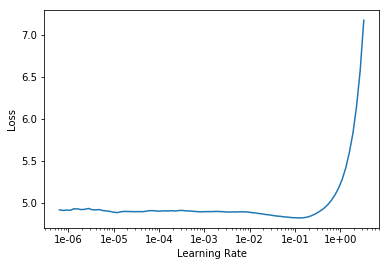

In [27]:
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(1, 1e-02moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.199922,3.996303,0.311143


Use ```learn.save()```, to save the weights of the model we trained just now. Load it back up by using ```learn.load()```.

In [29]:
learn.save('model-1')

In [ ]:
learn.model('model-1')

Use ```learn.unfreeze()```to unfeeze earlier layers. Read more about this [here](https://forums.fast.ai/t/can-someone-explain-precompute-true-and-freeze-or-unfreeze/18169/2)

In [31]:
learn.unfreeze()

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


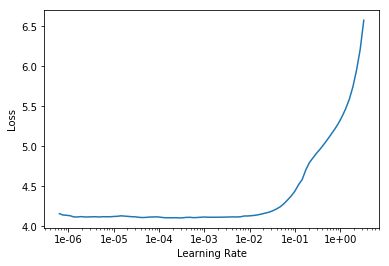

In [33]:
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(5, 1e-2, moms = (0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.058166,4.028416,0.305479
2,4.076521,4.050379,0.305864
3,3.826935,3.879514,0.324971
4,3.619037,3.717261,0.342926
5,3.312912,3.684012,0.348210


In [35]:
learn.save('enc')

In [ ]:
learn.load('enc')

After trainig the language model, we can ask it to predict the next words by giving it a couple of words in the beginning. Here, we give the words 'Trump's daughter' and ask it to predict the next 100 words. Results are hilarious:-)

In [39]:
learn.predict("Trump's daughter:", 100, temperature=0.5 ,min_p =0.001)

'Trump\'s daughter: " xxmaj if you look at the history of xxmaj trump \'s campaign , i \'m \' is a woman who does n\'t have a sense of experience , " xxmaj the xxmaj post wrote on xxmaj twitter . " xxmaj it \'s a very , very strange day . " \n\n xxmaj the xxmaj new xxmaj york xxmaj times : xxmaj trump xxmaj calls xxmaj him xxmaj out xxmaj of xxmaj his xxmaj own xxmaj mind xxmaj on xxmaj his xxmaj campaign xxmaj manager xxmaj for xxmaj his xxmaj entire xxmaj life xxmaj in xxmaj new xxmaj york xxmaj'

Now we can save the language model as an encoder

In [40]:
learn.save_encoder('enc-1')

In [41]:
learn.load_encoder('enc-1')

## Classifier

Now that we have built the language_model, we can go head and start with the Classifier. The Classifier is quite similar to the language_model. Following the same steps as before, will be fine



In [42]:
bs = 24

In [43]:
data_c = (TextList.from_df(df, cols='text', vocab=data_language.vocab)
            .random_split_by_pct(valid_pct=0.2)
            .label_from_df(cols='label')
            .databunch(bs=bs))

In [44]:
data_c.save('data-c')

In [46]:
path = Path("../Fake News - 1")

In [47]:
path.ls()

[PosixPath('../Fake News - 1/tmp_lm'),
 PosixPath('../Fake News - 1/.ipynb_checkpoints'),
 PosixPath('../Fake News - 1/Fake News - 1.ipynb'),
 PosixPath('../Fake News - 1/models'),
 PosixPath('../Fake News - 1/Untitled.ipynb'),
 PosixPath('../Fake News - 1/Data'),
 PosixPath('../Fake News - 1/data-c')]

In [ ]:
df = pd.read_csv(path/'fake_or_real_news.csv', usecols=["label", "text"])[["label", "text"]]

In [49]:
df.head()[:20]

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [50]:
data_c =  TextClasDataBunch.load(path, 'data-c', bs=bs)

Finally, we can create the actual classifier using the ```text_classifier``` in fast.ai

In [51]:
learn_classify = text_classifier_learner(data_c, drop_mult = 0.45)

In [52]:
learn_classify.load_encoder('enc-1')

In [53]:
learn_classify.freeze()

In [54]:
learn_classify.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


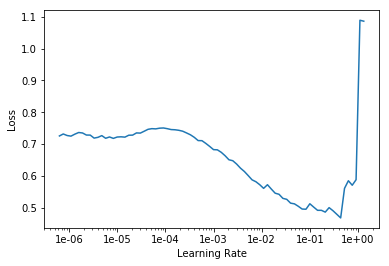

In [55]:
learn_classify.recorder.plot()

In [56]:
learn_classify.fit_one_cycle(1, 1e-2, moms = (0.8, 0.7))

epoch,train_loss,valid_loss,accuracy
1,0.187155,0.062389,0.973954


In [57]:

learn_classify.freeze_to(-2)
learn_classify.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.115290,0.035015,0.987372


In [58]:
learn_classify.save('penultimate')

In [ ]:
learn_classify.load('penultimate')

In [ ]:
learn_classify.load('penultimate')

<b>Finally, we have completed the classifier. Let's test it!</b>


Example 1: (FAKE)

In [90]:
learn_classify.predict("Hung Assembly in India. Modi defeated by Rahul Gandhi ans other UPA parties. BSP, SP and other parties have joined Congress. The people of India have given Modi a reality check, as a consequence of his miseading, damaging  and dishonest policies. Rahul Gandhi will take oath in 2 days!Other party leaders are slated to get lucrative ministries ")

(Category FAKE, tensor(0), tensor([0.9326, 0.0674]))

Example 2: (REAL)

In [92]:
learn_classify.predict(" Eight months after the BJP named him its prime ministerial candidate, Narendra Modi, 63, proved he was worth the opposition the party originally encountered over its decision. Mr Modi has delivered the BJP's best result ever, giving it more than the 272 seats it needs to form a government.  This is the first parliamentary majority by a single party since 1984")

(Category REAL, tensor(1), tensor([0.2880, 0.7120]))

As we see, the first short excrept was written by me and the second one was a <b>real</b> article from a newpaper and the model correctly classified it!

# Conclusion

### Takeaways
The model classifies Fake/Real by understanding the linguistic structure of the sentences. 

- In our example the first example was written by me in a very rudimentary and non-formal way, like most Fake News. 
- The second one, a proper news article, is a more professional and well-written article, like most of the Real News.

### Limitations 
As this model relies on the linguistic structure of a sentence, it is <b>by far</b> not a full proof Fake News Classifer.

- As it relies on the structure of a sentence, a well-written <b> Fake</b> article will be not be flagged down.
- Conversely, a poorly written <b> Real</b> article may be flagged down

These limitations can be undone, and am currently working on it!

References:
[The Excellent Fast.ai Course](https://github.com/fastai)
